*****Execution Started****
Reading my wishlist completed...Package_TataSkySD_UseCase1_ver4.xlsx
Reading all the pack details for the service provider completed...Package_TataSkySD_UseCase1_ver4.xlsx
Start processing the recommendation report ...Package_TataSkySD_UseCase1_ver4.xlsx
                                 Channel_Cost  Pack_Cost  Pack_Count  Savings
Pack_Name2                                                                   
TataSky Mal-Smart Pack                  90.86      72.00           8    18.86
Sun Kerala Basic pack                   37.76      23.60           4    14.16
TataSky Malayam-Regional Pack           83.78      70.00           7    13.78
Star Tamil-Malayalam Value Pack         70.80      57.82           6    12.98
Turner Bouquet 2 Pack                   21.84      11.80           3    10.04
Turner Bouquet 1 Pack                   10.04       5.02           2     5.02
Disc Kids Info Tamil Pack               10.62       7.08           3     3.54
Disc Kids Info p

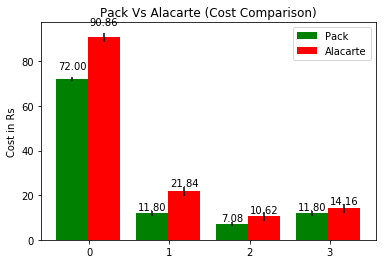

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fpdf import FPDF

import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders

import shutil
import os as osObj
import Configurator


def SendReport_EmailToReciepients(EMAILUSER,EMAILPWD,EMAILSENTTO,EMAILSUBJECT,
                                  RecTextReportPath,encoders,server,part,MIMEText,msg):
    '''
    send the recommendation report to recepient
    '''
    subject = 'PyPackage Recommender Report for ' + EMAILSUBJECT + ' Service Provider' # set the 'subject'
    msg['From'] = EMAILUSER
    msg['To'] = EMAILSENTTO
    #msg['Cc'] = EMAILUSER
    msg['Subject'] = subject

    body = 'Hi there, please find attached the recommendation report Generated from Python for your wishlist!'
    msg.attach(MIMEText(body,'plain'))

    #RecTextReportPath = 'Package_TataSky_NarayanaSwamy_ver4.txt' #code worked fine for text file kept in the same directory
    #RecTextReportPath = 'Package_TataSky_NarayanaSwamy_ver4.pdf'  #code worked fine for text file kept in the same directory

    filename= RecTextReportPath #set the 'filename'
    attachment  =open(filename,'rb')

    
    part.set_payload((attachment).read())
    encoders.encode_base64(part)
    part.add_header('Content-Disposition',"attachment; filename= "+filename)

    msg.attach(part)
    text = msg.as_string()
    
    server.starttls()
    server.login(EMAILUSER,EMAILPWD)

    server.sendmail(EMAILUSER,EMAILSENTTO,text)
    server.quit()
    

def WriteToPDF_PyChannelPackRecomReport(pdfHandler,blnAddPage=False, 
                              blnAddLine=False,RecText='',setWidth=0,setHeight=5,
                              setAlignment='',blnSETFONTforPage = False, setFont='Courier',setStyle='', setFontSize=10,
                              setBorder=0,blnPrintImage=False,setImagePath='',setX=10,setY=10):
    if blnPrintImage :
        pdfHandler.image(setImagePath, x=setX, y=setY, w=setWidth,h=setHeight)
    else:
        # Add a page
        if blnAddPage : pdfHandler.add_page()

        # Add a line
        if blnAddLine : pdfHandler.ln() 

        #set the font size and FONT and STYLE = 'B' for BOLD '' for regular
        if blnSETFONTforPage : pdfHandler.set_font(setFont,style=setStyle, size=setFontSize)

        #write to cell the recommnedaton text with the provided width,height,alignment
        pdfHandler.multi_cell(w=setWidth, h=setHeight,align=setAlignment, txt=RecText,border=setBorder)

def ReadMyWishListPackData(pd, Datafilename='',MonthlyNetworkFee=153.40,Ch_Type='SD',FilterQuery='KeepYesSD'):
    # Load spreadsheet
    xl = pd.ExcelFile(Datafilename)
    Email_IDs ='NEP'
    #set the custom columnnames that you want to use while parsing
    columnNames=['Channel_Name','Channel_Value','Channel_Cost_Per_Month','Chosen','Genre','Language','Ch_Type']
        
    #**Fetch & Store the data of MyPack in a new Data frame df_myCurrentPack Begin Code***
    df_myCurrentPack = pd.DataFrame([['Network Fee 0 to 100 Chs','153.40/Monthly',MonthlyNetworkFee,'Yes','NA','NA','SD']],
                                    columns=columnNames)
    
    # Get all the sheet names which has myCurrent Pack and other Packs to compare cost
    for sheetname in xl.sheet_names :
        # Load a sheet into a DataFrame by name: 
        if sheetname.lower() == 'mypack' :
            #df_myCurrentPack = xl.parse(sheetname,names=columnNames)
            dftemp = pd.DataFrame([],columns=columnNames)
            dftemp = xl.parse(sheetname,names=columnNames)
            df_myCurrentPack = df_myCurrentPack.append(dftemp)
        elif sheetname.lower() == 'myemail' :
            dftemp = xl.parse(sheetname,names=['EmailID'])
            dftemp['EmailID'] = dftemp['EmailID'].str.strip() #remove spaces
            dftemp = dftemp.drop_duplicates(keep='first') #remove duplicates
            Email_IDs = ';'.join(dftemp['EmailID'].tolist()) #add semicolon as email id seperator
    #**Fetch & Store the data of MyPack in a new Data frame df_myCurrentPack and the Packs in df_OtherAvailablePacks End Code***

    #********Clean up the data for spaces from the 2 dataframes Begin Code*******************************
    
    df_myCurrentPack['Channel_Name'] = df_myCurrentPack['Channel_Name'].str.strip() #remove spaces
    df_myCurrentPack['Channel_Name'] = df_myCurrentPack['Channel_Name'].str.lower() #convert to lower cases all the channels
    df_myCurrentPack['Genre'] = df_myCurrentPack['Genre'].str.strip()               #remove spaces
    df_myCurrentPack['Genre'] = df_myCurrentPack['Genre'].str.lower()               #convert to lower cases all the channels
    df_myCurrentPack['Language'] = df_myCurrentPack['Language'].str.strip()         #remove spaces
    df_myCurrentPack['Language'] = df_myCurrentPack['Language'].str.lower()         #convert to lower cases all the channels
    df_myCurrentPack['Ch_Type'] = df_myCurrentPack['Ch_Type'].str.strip() #remove spaces
 
    df_myCurrentPack['Pack_Name1'] = 'Alacarte'
    df_myCurrentPack['Broadcaster_x'] = 'Alacarte'
    df_myCurrentPack['Send_EmailTo'] = Email_IDs
    
    #Filter columns only Channel Name, Pack_Name and its monthly cost
    df_myCurrentPack = df_myCurrentPack.filter(items=['Channel_Name','Channel_Cost_Per_Month','Chosen',
                                                      'Send_EmailTo','Genre','Language','Ch_Type'])
    
    #Filter only Pack_Names which have cost greater than 0
    if FilterQuery =='KeepYesSD' :
        #df_myCurrentPack = df_myCurrentPack.query("Channel_Cost_Per_Month>0 and Chosen=='Yes' and Ch_Type=='" + Ch_Type +"'")
        df_myCurrentPack = df_myCurrentPack.query("Chosen=='Yes' and Ch_Type=='SD'")
    elif FilterQuery =='KeepYes' :
        df_myCurrentPack = df_myCurrentPack.query("Chosen=='Yes'")
    
    #print("before dropping duplicates ={}".format(df_myCurrentPack['Channel_Name'].count()))
    
    #after filtering for cost>0 and choosen = yes drop any duplicates
    df_myCurrentPack = df_myCurrentPack.sort_values(by=['Channel_Cost_Per_Month','Channel_Name'],ascending=[False,True])
    df_myCurrentPack = df_myCurrentPack.drop_duplicates(keep='first')
    df_myCurrentPack = df_myCurrentPack.reset_index(drop=True)
    
    #print("after dropping duplicates ={}".format(df_myCurrentPack['Channel_Name'].count()))
    
    #********Clean up the data for spaces from the 2 dataframes End Code*******************************
    return df_myCurrentPack

def ReadAllServiceProviderPackData(pd, Datafilename=''):
    
    # Load spreadsheet
    xl = pd.ExcelFile(Datafilename)
    
    #**Fetch & Store the data of MyPack in a new Data frame df_myCurrentPack and the Packs in df_OtherAvailablePacks Begin Code***
    blnInitializeOtherAvailablePacks = False
    
    # Get all the sheet names which has myCurrent Pack and other Packs to compare cost
    for sheetname in xl.sheet_names :
        # Load a sheet into a DataFrame by name: 
        if sheetname.lower() != 'mypack' and sheetname.lower() != 'myemail':
            #set the custom columnnames that you want to use
            columnNames=['Channel_Name','Pack_Value_Monthly','Pack_Cost_Per_Month']
            if  not blnInitializeOtherAvailablePacks:    
                df_OtherAvailablePacks = xl.parse(sheetname,names=columnNames)
                df_OtherAvailablePacks['Pack_Name2'] = sheetname
                df_OtherAvailablePacks['Broadcaster_y'] = sheetname.split()[0]
                blnInitializeOtherAvailablePacks = True
            else:
                dftemp = xl.parse(sheetname,names=columnNames)
                dftemp['Pack_Name2'] = sheetname
                dftemp['Broadcaster_y'] = sheetname.split()[0]
                df_OtherAvailablePacks = df_OtherAvailablePacks.append(dftemp)
    #**Fetch & Store the data of MyPack in a new Data frame df_myCurrentPack and the Packs in df_OtherAvailablePacks End Code***

    df_OtherAvailablePacks['Channel_Name'] = df_OtherAvailablePacks['Channel_Name'].str.strip() #remove spaces
    df_OtherAvailablePacks['Channel_Name'] = df_OtherAvailablePacks['Channel_Name'].str.lower() #convert to lower cases 
    df_OtherAvailablePacks['Pack_Name2'] = df_OtherAvailablePacks['Pack_Name2'].str.strip() #remove spaces
    df_OtherAvailablePacks['Broadcaster_y'] = df_OtherAvailablePacks['Broadcaster_y'].str.strip() #remove spaces
    df_OtherAvailablePacks['Savings'] = 0
    df_OtherAvailablePacks = df_OtherAvailablePacks.drop_duplicates(keep='first')

    #********Clean up the data for spaces from the 2 dataframes End Code*******************************
    return df_OtherAvailablePacks

def ProcessMyWishListDataToGenPyChannelPackageRecReport(pdf,fileHandler,osObj,pd, df_myCurrentPack, df_OtherAvailablePacks,
                                                        plt,np,Datafilename='',PyRecReportPath='',ServiceProvider='Tata Sky',
                                                       blnWriteToText=False,blnWriteToPDF=True):
    
    #Initialise the cost of selected packs
    CostofMypack = 0.0
    df_selectedpackNames = pd.DataFrame([],columns=['Pack_Name2','Pack_Cost_Per_Month','Channel_Cost','Savings'])
    
    #***Filter data from myCurrentPack to get only channels with cost > 0 and get total cost of pack with choosen= yes BEGIN Code**

    #Store the Original channels list in a Dataframe for removing them in each iteration
    df_remaining = df_myCurrentPack

    #compute the cost of current pack
    CostofMypack = df_myCurrentPack['Channel_Cost_Per_Month'].sum()

    #***Filter data from myCurrentPack to get only channels with cost > 0 and get total cost of pack with choosen= yes END Code**

    #******* Pick only those packs where we see any cost benefit and arrange them from max to mix selection order BEGIN CODE**
    #***This code is required to reduce iterations and ordering is CRITICAL to allow the projection from max selection to min

    df_mergedCostOrder = pd.merge(df_myCurrentPack,df_OtherAvailablePacks,how='inner',on='Channel_Name')
    #df_mergedCostOrder['Savings'] = df_mergedCostOrder['Pack_Cost_Per_Month'] - df_mergedCostOrder[]
    df_mergedCostOrder = df_mergedCostOrder.groupby('Pack_Name2').agg({'Channel_Cost_Per_Month' : sum, 
                                                                       'Pack_Cost_Per_Month':  max, 
                                                                       'Broadcaster_y': "count"}) 
    df_mergedCostOrder = df_mergedCostOrder.rename(columns = {'Broadcaster_y':'Pack_Count',
                                                              'Channel_Cost_Per_Month' : 'Channel_Cost',
                                                              'Pack_Cost_Per_Month':'Pack_Cost'})
    df_mergedCostOrder = df_mergedCostOrder[df_mergedCostOrder['Pack_Cost'] <= df_mergedCostOrder['Channel_Cost']]
    df_mergedCostOrder['Savings'] = df_mergedCostOrder['Channel_Cost']-df_mergedCostOrder['Pack_Cost']
    
    #fixed the sort column and mad ascending for pack count 
    #df_mergedCostOrder = df_mergedCostOrder.sort_values(by=['Pack_Count','Savings'],ascending=[False,False])
    df_mergedCostOrder = df_mergedCostOrder.sort_values(by=['Savings','Pack_Count'],ascending=[False,True])

    #print (df_mergedCostOrder)
    #Get the Packnames into a list and then use this for iterating through base and other pack comparison
    CostSavingsPackNameList = df_mergedCostOrder.index.tolist()

    #******* Pick only those packs where we see any cost benefit and arrange them from max to mix selection order End CODE**


    #***********Compare all the packs and fetch the optimum cost of the pack Outer Iteration Begin*************************
    for packname in CostSavingsPackNameList:

        df_CompPack = df_OtherAvailablePacks[df_OtherAvailablePacks['Pack_Name2']==packname]
        df_CompPack = df_CompPack.filter(items=['Channel_Name','Pack_Cost_Per_Month','Pack_Name2','Savings'])
        df_BaseMergePack = pd.merge(df_remaining,df_CompPack,how='inner',on='Channel_Name')

        CostSaving_forBasePack_per_month = df_BaseMergePack['Channel_Cost_Per_Month'].sum() - df_BaseMergePack['Pack_Cost_Per_Month'].max()

        df_BaseMergePack['Channel_Cost'] = df_BaseMergePack['Channel_Cost_Per_Month'].sum()
        df_BaseMergePack['Savings'] = CostSaving_forBasePack_per_month
        df_CompPack['Savings'] = CostSaving_forBasePack_per_month

        df_BasePack = df_BaseMergePack.filter(items=['Channel_Name','Channel_Cost_Per_Month'])
        
        
        blnLessCostPackfound = False
        #**************compare only when the CostSaving_forBasePack_per_month is greater than 0 begin code*******
        if (CostSaving_forBasePack_per_month>=0) :

            #****************compare base with other packs through iteration Begin**************************************************
            for comparepackname in CostSavingsPackNameList:
                if comparepackname != packname:

                    #compare the other packs cost with this cost
                    df_OtherPack = df_OtherAvailablePacks[df_OtherAvailablePacks['Pack_Name2']==comparepackname]
                    df_OtherPack = df_OtherPack.filter(items=['Channel_Name','Pack_Cost_Per_Month','Pack_Name2','Savings'])
                    df_mergedComp = pd.merge(df_BasePack,df_OtherPack,how='inner',on='Channel_Name')

                    CostSaving_forOtherPack_per_month =  df_mergedComp['Channel_Cost_Per_Month'].sum() - df_mergedComp['Pack_Cost_Per_Month'].max()

                    df_mergedComp['Channel_Cost'] = df_mergedComp['Channel_Cost_Per_Month'].sum()
                    df_mergedComp['Savings'] = CostSaving_forOtherPack_per_month.round(2)
                    df_OtherPack['Savings'] = CostSaving_forOtherPack_per_month.round(2)
                    if (CostSaving_forOtherPack_per_month > CostSaving_forBasePack_per_month) :
                        #select this pack as this is offering better cost and discard the other
                        #Store the packname and costs in another temp dataframe
                        dftemp = df_mergedComp.filter(items=['Pack_Name2','Pack_Cost_Per_Month','Channel_Cost','Savings'])
                        dftemp = dftemp.drop_duplicates()
                        blnLessCostPackfound = True
            #****************compare base with other packs through iteration End**************************************************

            if blnLessCostPackfound :
                #Store the dftemp packname into df_selectedpackNames data frame as that was the best among the comparison
                df_selectedpackNames = df_selectedpackNames.append(dftemp)

                #Remove only those channels where a selection is made and retain others so that duplicate selection is avoided 
                #and other channel gets a chance for selection during the succesive iterations
                SelectedPackName = dftemp['Pack_Name2'].unique()
                dftemp = df_OtherAvailablePacks[df_OtherAvailablePacks['Pack_Name2']==SelectedPackName[0]]
                dftemp = dftemp.filter(items=['Channel_Name'])
                dftemp = dftemp.drop_duplicates()
                df_remaining = df_remaining[~df_remaining['Channel_Name'].isin(dftemp['Channel_Name'])]
            else:
                #Store the Base pack if the Savings is more than 0 as that is the best into df_selectedpackNames data frame
                dftemp  = df_BaseMergePack[df_BaseMergePack['Savings']>0]
                dftemp = df_BaseMergePack.filter(items=['Pack_Name2','Pack_Cost_Per_Month','Channel_Cost','Savings'])
                dftemp = dftemp.drop_duplicates()
                df_selectedpackNames = df_selectedpackNames.append(dftemp)
                #Remove the channels when a selection is made so as to avoid duplicate selection during the succesive iterations
                df_remaining = df_remaining[~df_remaining['Channel_Name'].isin(df_BasePack['Channel_Name'])]
        #else:
            #ignore the negative savings and we dont remove any channels but use them for next pack comparison
            ##print("Packname {} has cost = {}".format(packname,CostSaving_forBasePack_per_month))

        #**************compare only when the CostSaving_forBasePack_per_month is greater than 0 End code*******

    #***********Compare all the packs and fetch the optimum cost of the pack Outer Iteration End*************************


    #********************Make the recommendations BEGIN******************************************************************
    #Get all the channels from the selected packs in a df_SelectedChannelsList dataframe to see what additional channels user gets

    df_SelectedChannelsList = df_OtherAvailablePacks[df_OtherAvailablePacks['Pack_Name2'].
                                                     isin(df_selectedpackNames['Pack_Name2'])].filter(items=['Channel_Name'])
    ##print(df_SelectedChannelsList)
    #******* First print the current Pack details BEGIN CODE**************************************************************

    #******write to pdf using FPDF module**************************************BEGIN CODE*********************
    #Create a FPDF object and start writing to PDF******Page 1 details Begin Code**********************************
    #pdf = FPDF()
    #RecommendationText = ("Tata Sky Package Recommendation Report")
    RecommendationText = ("PyPackage(Channel) Recommendation Report for " + ServiceProvider + " Service Provider")
    if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=True,blnAddLine=True,RecText=RecommendationText,setWidth=0,setHeight=5,
                              setAlignment='C',blnSETFONTforPage = True, setFont='Courier',setStyle='B', setFontSize=14)
    if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
    
    RecommendationText = ("Below are the list of channels that you have chosen to view as part of the Pack:")
    if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=12)
    if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
    #print(RecommendationText)

    #Adding the current pack Header
    RecommendationText = ("*" *70)
    if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12)
    if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
    #Display the current pack selection which have cost>0 choose =yes
    #print(RecommendationText)

    #Adding the current pack Details

    RecommendationText = df_myCurrentPack.to_string()
    SplitLineText = RecommendationText.splitlines()

    ##print("MyCurrentPackin Sting")
    ##print(RecommendationText)
    blnPrintHeader = False
    for eachLine in SplitLineText:
        #pdf.cell(200, 10, txt=RecommendationText, ln=0, align="L")
        if not blnPrintHeader: 
            eachLine = eachLine.replace('Channel_Name','Channel Name')
            eachLine = eachLine.replace('Channel_Cost_Per_Month','Channel Cost')
            eachLine = eachLine.replace('Chosen','Chosen')
            eachLine = eachLine.title()
            if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=eachLine,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12)
            if blnWriteToText : fileHandler.writelines(eachLine+"\n")
            RecommendationText = ("*" *70)
            if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12)
            if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
            blnPrintHeader = True
        else:
            eachLine = eachLine.title()
            if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=eachLine,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=10)
            if blnWriteToText : fileHandler.writelines(eachLine+"\n")
    #print(df_myCurrentPack)

    #Adding the current pack footer
    RecommendationText = ("-"*70)
    #print(RecommendationText)
    if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=12)
    if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
    
    #Adding the current pack Cost details
    RecommendationText = "Cost of the Your current Pack (Rs)= {:5.2f}".format(CostofMypack)
    #print(RecommendationText)
    if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12)
    if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
    
    #Adding the current pack footer
    RecommendationText = ("-" *70)
    #print(RecommendationText)
    if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12)
    if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
    
    #******* First print the current Pack details END CODE**************************************************************
    #Create a FPDF object and start writing to PDF******Page 1 details End Code**********************************

    if df_selectedpackNames['Pack_Name2'].count()==0 :

        RecommendationText = "There are NO packs available that offer any cost savings for the channels chosen by you."
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=True,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=12)
        #print(RecommendationText)
        if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")

        RecommendationText = "Hence, Recommendation is that you buy them as ALACARTE."
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12)
        #print(RecommendationText)
        if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
    
    else:
        #********Next show the selected pack with savings that it will make Begin code***************************************
        CostofSelectedPacks = 0
        RecommendationText = ""

        #****************************Start the selected package details in the SECOND PAGE  Begin Code **********************

        #Adding recommended package in page no 2
        RecommendationText = "The Recommendation is to add the below package(s) to your current pack:"
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=True,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=12)
        #print(RecommendationText)
        if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
        
        #Adding a Header
        RecommendationText = ("-" *70)
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12)
        #print(RecommendationText)
        if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
        
        df_selectedpackNames = df_selectedpackNames.reset_index(drop=True)

        #add the recommended package names with cost
        RecommendationText = df_selectedpackNames.filter(items=['Pack_Name2','Pack_Cost_Per_Month','Channel_Cost','Savings']).to_string()
        SplitLineText = RecommendationText.splitlines()
        blnPrintHeader = False

        for eachLine in SplitLineText:
            #pdf.cell(200, 10, txt=RecommendationText, ln=0, align="L")
            if not blnPrintHeader: 
                eachLine = eachLine.replace('Pack_Name2','Pack Name')
                eachLine = eachLine.replace('Pack_Cost_Per_Month','Pack Cost')
                eachLine = eachLine.replace('Channel_Cost','Channel Cost')
                eachLine = eachLine.replace('Savings','Savings')
                eachLine = eachLine.title()
                if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=eachLine,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=12)
                if blnWriteToText : fileHandler.writelines(eachLine+"\n")
                RecommendationText = ("-" *70)
                if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12)
                if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
                blnPrintHeader = True
            else:
                eachLine = eachLine.title()
                if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=eachLine,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=10)
                if blnWriteToText : fileHandler.writelines(eachLine+"\n")
                
        #print(df_selectedpackNames.filter(items=['Pack_Name2','Pack_Cost_Per_Month','Channel_Cost','Savings']))
        #Adding a Cost in the footer
        pdf.set_font("Courier", size=12)
        CostofSelectedPacks += df_selectedpackNames['Pack_Cost_Per_Month'].sum().round(2)
        RecommendationText = ("=" *70)
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=12)
        #print(RecommendationText)
        if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
        
        #Adding the Cost details in the footer
        RecommendationText = ("Cost of the Recommended pack(s) (Rs)= {} ".format(CostofSelectedPacks))
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12)
        #print(RecommendationText)
        if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
        
        #Adding a Cost in the footer
        RecommendationText = ("=" *70)
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12)
        #print(RecommendationText)
        if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
        
        #****************************Start the selected package details in the SECOND PAGE  End Code **********************

        #*********Plot a bar graph to show the difference of choosing the pack vs alacarte Begin Code***

        N = df_selectedpackNames['Pack_Name2'].count()
        #N = 1
        Alc_cost = (df_selectedpackNames['Pack_Cost_Per_Month'])
        #Alc_cost = (df_mergedPack['Monthly_Cost_in_Rs'].sum().round(2))
        Alc_std = (np.ones(N))
        #Alc_std = (1, )

        ind = np.arange(N)   # the x locations for the groups
        width = 0.4         # the width of the bars

        fig, ax = plt.subplots()
        rects1 = ax.bar(ind + width, Alc_cost, width, color='g', yerr=Alc_std)

        #Pack_cost = (CostOfOthPack.round(2), )
        Pack_cost = (df_selectedpackNames['Channel_Cost'])
        Pack_std  = (np.ones(N)+np.ones(N))
        #Pack_std = (1, )
        rects2 = ax.bar(ind + width*2, Pack_cost, width, color='r', yerr=Pack_std)

        # add some text for labels, title and axes ticks
        ax.set_ylabel('Cost in Rs')
        ax.set_title('Pack Vs Alacarte (Cost Comparison)')
        ax.set_xticks(ind + width / 0.65)
        #ax.set_xticklabels(('Packs',))
        #ax.set_xticklabels(df_selectedpackNames['Pack_Name2'],rotation=90)
        ax.set_xticklabels(df_selectedpackNames.index.tolist(),rotation=0)

        ax.legend((rects1[0], rects2[0]), ('Pack', 'Alacarte'),loc='upper right')

        def autolabel(rects):
            """
            Attach a text label above each bar displaying its height
            """
            for rect in rects:
                height = rect.get_height()
                ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,'%.2f' % float(height),ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)

        #****************************Print the Graph in the THIRD PAGE  Begin Code **********************
        #osObj.chdir('C:/Users/God/Documents/Venkatesh/INSAID/Anaconda-SW/NumpyAndPandas/TataSky/RecommendationReport')
        #osObj.chdir(Configurator.PyPackRecReportPath)
        osObj.chdir(PyRecReportPath)
        RecomReport_Dir = osObj.getcwd()
        #Extract the Excel filename and rename it to png for Recommendation report
        ExcelFileName = Datafilename[Datafilename.rfind("\\")+1:] 
        ##print(ExcelFileName)
        #image_path =osObj.getcwd() + "\\" + 'PackVsAlacarteSavingsChart.png'
        image_path = osObj.path.join(RecomReport_Dir, ExcelFileName.replace("xlsx","png"))
        
        #Saving the graph into png file
        plt.savefig(image_path) 
        ##print(image_path)
        
        #Adding graph in page no 3
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=True,blnAddLine=False,RecText='',setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=12)
        setHeight = 75
        setWidth = 190
        setX = 10
        setY = 10
        #pdf.image(image_path, x=10, y=10, w=200,h=setHeight)
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=setWidth,setHeight=setHeight,
                              setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12,
                                  blnPrintImage=True,setImagePath=image_path,setX=setX,setY=setY)
        #plt.show()

        #show the pack name with channels offered
        setHeight += 5
        #Print a blank row of the same height as that of the graph image
        RecommendationText=''
        #pdf.multi_cell(w=setWidth, h=setHeight, txt=RecommendationText,border=0,align='')
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=setWidth,setHeight=setHeight,
                              setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12,setBorder=0)
        setHeight = 5
        setIndex = 0
        RecommendationText='Legend'
        #pdf.multi_cell(w=setWidth, h=setHeight, txt=RecommendationText,border=0,align='')
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=setWidth,setHeight=setHeight,
                              setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12,setBorder=0)

        for PackName in df_selectedpackNames['Pack_Name2'].tolist():
            LegendName = str(setIndex) + '-' + PackName + '--->['
            LegendName += ','.join(df_OtherAvailablePacks[df_OtherAvailablePacks['Pack_Name2']==PackName]
                                   ['Channel_Name'].tolist()).title()
            LegendName += ']'
            LegendName += '(' + str(df_OtherAvailablePacks[df_OtherAvailablePacks['Pack_Name2']==PackName]['Channel_Name'].count()) + ')'
            
            ##print(LegendName)
            #pdf.multi_cell(w=200, h=setHeight, txt=LegendName,border=0,align='')
            if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=LegendName,setWidth=setWidth,setHeight=setHeight,
                              setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=10,setBorder=1)
            setIndex +=1

        #*********Plot a bar graph to show the difference of choosing the pack vs alacarte End Code***

        #****************************Print the Graph in the THIRD PAGE  End Code **********************

        #********Next show the selected pack with savings that it will make End code************************************


        #********Next show the individual channels that could not go in with any pack Begin code*************************
        #********Start writing individual channels into FOURTH PAGE Begin Code*********************************
        #Add alcarte details in a new page - page no 4
        #Get the remaining by removing the selected channels from selectepackName
        df_remaining = df_myCurrentPack[~df_myCurrentPack['Channel_Name'].isin(df_SelectedChannelsList['Channel_Name'])]
        
        #print(df_remaining)
        
        #Get the additional channels from the selected packs that were not part of the current list
        #Lets use the set theory and use DIFFERENCE operation to achieve the results 
        
        #Get the selected channels in a new set from the dataframe of selectec packs
        SelectedChannels=set(df_SelectedChannelsList['Channel_Name'])

        #Get the original channels from current pack list in another set
        OriginalChannels=set(df_myCurrentPack['Channel_Name'])

        #AdditionalChannels = SelectedChannels - OriginalChannels
        AdditionalChannels = SelectedChannels.difference(OriginalChannels)
        #print("mypack count ={}".format(df_myCurrentPack['Channel_Name'].count()))
        #print("addition count={}".format(len(AdditionalChannels)))
        if df_remaining['Channel_Name'].count()==1 :
            if df_myCurrentPack['Channel_Name'].count() + len(AdditionalChannels) <=124 :
                RecommendationText = "Add the Network Fee :"
            elif df_myCurrentPack['Channel_Name'].count() + len(AdditionalChannels) > 124 :
                RecommendationText = "Add the Network Fee + Fee for Subsequent 25 channels:"
                #add the Fee for subsequent 25 channels
                FeeSub25Chs = (df_myCurrentPack['Channel_Name'].count() + len(AdditionalChannels)) - 100
                FeeSub25Chs = int(FeeSub25Chs/25) * 23
                dftemp = pd.DataFrame([['Fee for Subsequent 25 Chs',FeeSub25Chs]],
                                      columns=['Channel_Name','Channel_Cost_Per_Month'])
                df_remaining = df_remaining.append(dftemp,ignore_index = True)
        else:
            if df_myCurrentPack['Channel_Name'].count() + len(AdditionalChannels) <=124 :
                RecommendationText = "Add the Network Fee plus below channels as Alacarte:"
            elif df_myCurrentPack['Channel_Name'].count() + len(AdditionalChannels) > 124 :
                
                RecommendationText = "Add the Network Fee + Fee for Subsequent 25 channels plus below channels as Alacarte:"
                #add the Fee for subsequent 25 channels
                FeeSub25Chs = (df_myCurrentPack['Channel_Name'].count() + len(AdditionalChannels)) - 100
                FeeSub25Chs = int(FeeSub25Chs/25) * 23
                dftemp = pd.DataFrame([['Fee for Subsequent 25 Chs',FeeSub25Chs]],
                                      columns=['Channel_Name','Channel_Cost_Per_Month'])
                df_remaining = df_remaining.append(dftemp,ignore_index = True)
        
        df_remaining = df_remaining.filter(items=['Channel_Name','Channel_Cost_Per_Month'])
        df_remaining = df_remaining.sort_values(by=['Channel_Cost_Per_Month','Channel_Name'],ascending=[False,True])
        df_remaining = df_remaining.drop_duplicates(keep='first')
        df_remaining = df_remaining.reset_index(drop=True)
        
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=True,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=12,setBorder=0)
        #print(RecommendationText)
        if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
        
        RecommendationText = ("=" *70)
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                              setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12,setBorder=0)
        #print(RecommendationText)
        if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
        
        #add the recommended package names with cost
        RecommendationText = df_remaining.to_string()
        SplitLineText = RecommendationText.splitlines()

        ##print(RecommendationText)
        blnPrintHeader = False
        for eachLine in SplitLineText:
            #pdf.cell(200, 10, txt=RecommendationText, ln=0, align="L")
            if not blnPrintHeader: 
                eachLine = eachLine.replace('Channel_Name','Channel Name')
                eachLine = eachLine.replace('Channel_Cost_Per_Month','Channel Cost')
                eachLine = eachLine.title()
                if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=eachLine,setWidth=0,setHeight=5,
                                          setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12)
                RecommendationText = ("=" *70)
                if blnWriteToText : fileHandler.writelines(eachLine+"\n")
                if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                                          setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12)
                if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
                blnPrintHeader = True
            else:
                eachLine = eachLine.title()
                if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=eachLine,setWidth=0,setHeight=5,
                                          setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=10)
                if blnWriteToText : fileHandler.writelines(eachLine+"\n")
        
        #compute the cost of alacarte + network + Fee for sub 25 chs  
        CostofSelectedPacks += df_remaining['Channel_Cost_Per_Month'].sum().round(2)
        
        RecommendationText = ("=" *70)
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                                  setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=12)
        #print("=" *100)
        if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
        if df_remaining['Channel_Name'].count()==1 :
            if df_myCurrentPack['Channel_Name'].count() + len(AdditionalChannels) <=124 :
                RecommendationText = ("Cost of Network Fee (Rs)= {}".format(df_remaining['Channel_Cost_Per_Month'].sum().round(2)))
            elif df_myCurrentPack['Channel_Name'].count() + len(AdditionalChannels) > 124 :
                RecommendationText = ("Cost of Network Fee + Fee for Subsequent 25 chs (Rs)= {}".format(df_remaining['Channel_Cost_Per_Month'].sum().round(2)))
        else:
            if df_myCurrentPack['Channel_Name'].count() + len(AdditionalChannels) <=124 :
                RecommendationText = ("Cost of Network Fee & Alacarte (Rs)= {}".format(df_remaining['Channel_Cost_Per_Month'].sum().round(2)))
            elif df_myCurrentPack['Channel_Name'].count() + len(AdditionalChannels) > 124 :
                RecommendationText = ("Cost of Network Fee + Fee for subsequent 25 chs & Alacarte (Rs)= {}".format(df_remaining['Channel_Cost_Per_Month'].sum().round(2)))
                
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                                  setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12)
        #print(RecommendationText)
        if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
        
        RecommendationText = ("=" *70)
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                                  setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12)
        #print("=" *100)
        if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
        
        #********Next show the individual channels that could not go in with any pack End code*************************
        #********Finally show the Total cost of new pack and its Savings & print the additional channels user will benefit Begin code*
        #print(" " *100)
        #print(" " *100)

        RecommendationText = ("$" *70)
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=True,RecText=RecommendationText,setWidth=0,setHeight=5,
                                  setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12)
        #print("$" *100)
        if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
        
        if df_remaining['Channel_Name'].count() == 1 :
            if df_myCurrentPack['Channel_Name'].count() + len(AdditionalChannels) <=124 :
                RecommendationText = ("Total Cost[Recommended Pack({})+NetworkFee({})](Rs)= {}".
                                      format(df_selectedpackNames['Pack_Cost_Per_Month'].sum().round(2),
                                             df_remaining['Channel_Cost_Per_Month'].sum().round(2),
                                             CostofSelectedPacks.round(2)))
            elif df_myCurrentPack['Channel_Name'].count() + len(AdditionalChannels) > 124 :
                RecommendationText = ("Total Cost[Recommended Pack({})+(NetworkFee+Fee for Subsquent 25chs)({})](Rs)= {}".
                                      format(df_selectedpackNames['Pack_Cost_Per_Month'].sum().round(2),
                                             df_remaining['Channel_Cost_Per_Month'].sum().round(2),
                                             CostofSelectedPacks.round(2)))
        else:
            if df_myCurrentPack['Channel_Name'].count() + len(AdditionalChannels) <=124 :
                RecommendationText = ("Total Cost[Recommended Pack({})+(NetworkFee+Alacarte)({})](Rs)= {}".
                                      format(df_selectedpackNames['Pack_Cost_Per_Month'].sum().round(2),
                                             df_remaining['Channel_Cost_Per_Month'].sum().round(2),
                                             CostofSelectedPacks.round(2)))
            elif df_myCurrentPack['Channel_Name'].count() + len(AdditionalChannels) > 124 :
                RecommendationText = ("Total Cost[Recommended Pack({})+(NetworkFee+Fee for Subsquent 25chs+Alacarte)({})](Rs)= {}".
                                      format(df_selectedpackNames['Pack_Cost_Per_Month'].sum().round(2),
                                             df_remaining['Channel_Cost_Per_Month'].sum().round(2),
                                             CostofSelectedPacks.round(2)))
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                                  setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=11)
        #print(RecommendationText)
        if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
        
        RecommendationText = ("You Save({}-{}) (Rs)= {}".format(CostofMypack.round(2),CostofSelectedPacks.round(2),
                                                (CostofMypack - CostofSelectedPacks).round(2)))
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                                  setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=11)
        #print(RecommendationText)
        if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")

        RecommendationText = ("$" *70)
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                                  setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=12)
        #print("$" *100)
        if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
        
        if len(AdditionalChannels) > 0 :
            RecommendationText ="Your had {} channels in your wishlist but now you will be able to watch {} channel(s) additional.".format((df_myCurrentPack["Channel_Name"].count()-1),len(AdditionalChannels))
            RecommendationText +="The Total number of channels in your Recommended pack ={}.".format((df_myCurrentPack["Channel_Name"].count()-1)+len(AdditionalChannels))
            RecommendationText +="See the next page for the additional channels list.\n"
            if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=True,RecText=RecommendationText,setWidth=0,setHeight=5,
                                      setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=10,setBorder=0)
            #print("$" *100)
            if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
        else:
            RecommendationText ="Your had {} channels in your wishlist which you can retain with the above recommendation.\n".format((df_myCurrentPack["Channel_Name"].count()-1))
            if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=True,RecText=RecommendationText,setWidth=0,setHeight=5,
                                      setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=10,setBorder=1)
            #print("$" *100)
            if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
        
        
        RecommendationText = '*All prices above are inclusive of taxes. Network Fee (NCF) is charged on the basis of the total channel count.\n'
        RecommendationText += 'NCF for the first 100 channels is Rs. 153/- per month inclusive of taxes and for every \n'
        RecommendationText += 'subsequent 25 channels it is Rs. 23/- per month inclusive of taxes. 1 HD channel is treated as \n'
        RecommendationText += '2 SD channels in the channel count.Terms and conditions of the Subscription Contract Apply.\n'
        
        if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                                  setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=8,setBorder=1)
        if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
        #********Start writing individual channels into FOURTH PAGE End Code*********************************
        #******Write the additional channels details in the FIFTH PAGE Begin Code**********************************
                
        #Show only when there are additional channels to view Begin code
        if len(AdditionalChannels) > 0 :
            #in the last page - Page no 5 show all the additional channels 
            RecommendationText = ("Below are the Additional Channels that you will be able to watch: ")
            if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=True,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                                      setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=12)
            #print(RecommendationText)
            if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")

            RecommendationText = ("=" *70)
            if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                                      setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12)
            #print(RecommendationText)
            if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")

            RecommendationText = ("Chanel Name")
            if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                                      setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12)
            #print(RecommendationText)
            if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")

            RecommendationText = ("=" *70)
            if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                                      setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=12)
            #print(RecommendationText)
            if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")


            #Iterate through set elements to display the additional channels
            #df_AdditionalChannelsList = df_SelectedChannelsList[~df_SelectedChannelsList['Channel_Name'].isin(df_myCurrentPack['Channel_Name'])]
            #df_AdditionalChannelsList = df_AdditionalChannelsList.filter(items=['Channel_Name']).sort_values('Channel_Name',ascending=True)
            #df_AdditionalChannelsList = df_AdditionalChannelsList.drop_duplicates()
            #df_AdditionalChannelsList = df_AdditionalChannelsList.reset_index(drop=True)
            ##print(df_AdditionalChannelsList['Channel_Name'].str.title())

            RecommendationText =""
            if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=0,
                                      setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=10)
            setIndex = 0
            for channels in AdditionalChannels:
                RecommendationText = str(setIndex) + '-' + channels.title()
                setIndex += 1
                if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                                          setAlignment='L',blnSETFONTforPage = False,setFont='Courier',setStyle='', setFontSize=10)
                #print(RecommendationText)
                if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")

            #add a footer to additional channel list
            RecommendationText = ("=" *70)
            if blnWriteToPDF : WriteToPDF_PyChannelPackRecomReport(pdf,blnAddPage=False,blnAddLine=False,RecText=RecommendationText,setWidth=0,setHeight=5,
                                      setAlignment='L',blnSETFONTforPage = True,setFont='Courier',setStyle='', setFontSize=12)
            #print("=" *100)
            if blnWriteToText : fileHandler.writelines(RecommendationText+"\n")
        #Show only when there are additional channels to view End code
        #******Write the additional channels details in the FIFTH PAGE End Code**********************************

    #osObj.chdir('C:/Users/God/Documents/Venkatesh/INSAID/Anaconda-SW/NumpyAndPandas/TataSky/RecommendationReport')
    #osObj.chdir(Configurator.PyPackRecReportPath)
    osObj.chdir(PyRecReportPath)
    RecomReport_Dir = osObj.getcwd()
    #Extract the Excel filename and rename it to pdf for Recommendation report
    ExcelFileName = Datafilename[Datafilename.rfind("\\")+1:] 
    ##print(ExcelFileName)
    if blnWriteToText : RecReportPath = osObj.path.join(RecomReport_Dir, ExcelFileName.replace("xlsx","txt"))
    if blnWriteToPDF : RecReportPath = osObj.path.join(RecomReport_Dir, ExcelFileName.replace("xlsx","pdf"))
    
    ##print(RecReportPath)
    if blnWriteToPDF : pdf.output(RecReportPath)
    
    #close the fileHandler
    if blnWriteToText : fileHandler.close()
    
    #*********** Recommendation report to PDF writing completed*******************

    #********Finally show the Total cost of new pack and its Savings & print the additional channels user will benefit End code*

    #********************Make the recommendations END******************************************************************

##################################################################################################
#Reading data from the excle file so change directory to location where you have kept the WishList 
##################################################################################################
osObj.chdir('C:\\Users\\God\\Documents\\Venkatesh\\INSAID\\Anaconda-SW\\NumpyAndPandas')

Datafilename = 'Package_TataSkySD_UseCase1_ver4.xlsx'
#Datafilename = 'Package_TNMulticityDigitalSD_User1_ver4.xlsx'
#Datafilename = 'Package_TataSkySD_FamilyKidsSports.xlsx'
#Datafilename = 'Package_TataSkySD_FamilyKidsSports_Test.xlsx'
ExcelFileName = Datafilename[Datafilename.rfind("\\")+1:] 
CurrDirectory = osObj.getcwd()

#ServiceProviderName = 'TNMulticityDigital'
ServiceProviderName = 'TataSky'
SPPackfilename = osObj.path.join(CurrDirectory, ExcelFileName)
#print(SPPackfilename)

print("*****Execution Started****")

#Read the Wsihlist and email id details for the user provided in MyPack and MyEmail worksheet
df_myCurrentPack = ReadMyWishListPackData(pd,Datafilename=SPPackfilename,MonthlyNetworkFee=Configurator.MonthlyNetworkFee,
                                          FilterQuery='KeepYesSD')

email_send = ','.join(df_myCurrentPack['Send_EmailTo'].unique()) # set the 'recipient_email'
df_myCurrentPack = df_myCurrentPack.filter(items=['Channel_Name','Channel_Cost_Per_Month','Chosen'])
print("Reading my wishlist completed..." + Datafilename)

#Read all the pack data for the service provider from other sheets 
df_OtherAvailablePacks = ReadAllServiceProviderPackData(pd,SPPackfilename)
print("Reading all the pack details for the service provider completed..." + Datafilename)

#Create an object of FPDF to be passed to the function
print("Start processing the recommendation report ..." + Datafilename)
pdf = object()
pdf = FPDF()


#create empty object to pass the filehandler if you wish to write to text uncomment the open() line
fileHandler = object()
#fileHandler = open(RecTextReportPath,'w')
#fileHandler.seek(0)
ProcessMyWishListDataToGenPyChannelPackageRecReport(pdf, fileHandler, osObj, pd, df_myCurrentPack, df_OtherAvailablePacks,
                                                  plt,np,Datafilename=SPPackfilename,
                                                    PyRecReportPath=CurrDirectory,
                                                    ServiceProvider=ServiceProviderName,blnWriteToText=False,blnWriteToPDF=True)

print("Recommendation report completed...."+ Datafilename)

#********** send the report email begin code ************************************
if email_send.upper() == "NEP" or email_send.strip() =='' :
    print('no email sent since no email id provided....')
else:
    #Send the report via email to the recepient
    print('sending email report started....')
    email_msgmp = MIMEMultipart()
    email_user = Configurator.EMAIL # set 'your_email'
    email_password = Configurator.PASSWORD # set 'your_password'

    server = smtplib.SMTP('smtp.gmail.com',587)
    part = MIMEBase('application','octet-stream')
    
    #Send the email attaching the text report in the prog path directory
    RecPDFReportPath = ExcelFileName.replace("xlsx","pdf")
    #RecPDFReportPath = ExcelFileName.replace("xlsx","txt")
    
    SendReport_EmailToReciepients(email_user,email_password,email_send,ServiceProviderName,RecPDFReportPath,encoders,
                                  server,part,MIMEText,msg=email_msgmp)
    print('email message with attachment sent successfully to ' + email_send + '....' )

print("*****Execution Completed****")
